In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
# pip install torch==1.0.0 torchvision==0.2.1 -f https://download.pytorch.org/whl/cu80/torch_stable.html
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu80
# https://download.pytorch.org/whl/cu80/torch-1.0.0-cp35-cp35m-win_amd64.whl
# pip install torch -f https://download.pytorch.org/whl/cu80/torch-1.0.0-cp35-cp35m-win_amd64.whl
# pip install torch -f /d/3.Install/torch-1.0.0-cp37-cp37m-win_amd64.whl (success)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
# pip install torchsummary
from torchsummary import summary

In [2]:
# torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
print(config['data']['frame_size'])

512


In [4]:
fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [5]:
# TODO : loading each fold for taining
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
        self.folds = list(([28,   26,  24,  16,   6,   4,   2,  8, 20, 21, 22, 24, 25], # 7 HC + 6 ALS
                           [65,   63,  61,  53,  49,  42,  27, 28, 31, 32, 39, 42, 46], # 6 HC + 7 ALS
                           [97,   89,  86,  85,  81,  77,  48, 52, 55, 58, 62, 64, 68], # 6 HC + 7 ALS
                           [117, 115, 113, 111, 109, 107,  99, 72, 76, 78, 80, 84, 92], # 7 HC + 6 ALS
                           [131, 129, 127, 125, 123, 121, 119, 94, 96, 98,100,102]))     # 7 HC + 5 ALS

        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        self.X = np.zeros((20000, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            else:
                ids_train.append(i)
        return (ids_train, ids_test)

label =  0.0


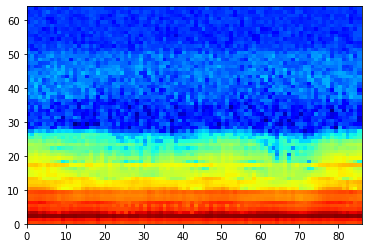

In [7]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(320)

plt.pcolor(X_generic, cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_test = DataSet_ALS.get_kth_fold_inds(4)

### 5-fold CV procedure

In [ ]:
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

# define a cross validation function
def crossvalid(model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)

    for i in range(len(DataSet_ALS.folds)):
        
        inds_train,inds_test = DataSet_ALS.get_kth_fold_inds(i)        
        
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
        
#         print(len(train_set),len(val_set))
#         print()
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(model,criterion,optimizer,train_loader,epoch=10)
        train_score.at[i] = train_acc

        # TODO: prediction on test set

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return train_score,val_score
        

train_score,val_score = crossvalid(model,criterion,optimizer,dataset=DataSet_ALS)

### NN-model

In [55]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        self.frames_in_segment = config['data']['supra_frame_length']
        self.fc = nn.Linear(self.n_mel*self.frames_in_segment,1)
        nn.init.xavier_uniform_(self.fc.weight, gain=1.0)
    
    def forward(self, x):
        out = x.view(-1,self.n_mel*self.frames_in_segment)
        out = self.fc(out)
        return out    

In [61]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):    
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        iter = 1
        for specs, labels in train_loader:
            specs = specs.float()
            outputs = model(specs)
            outputs = outputs.squeeze()            
            # print(outputs)
            # print(labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            if iter%500==0:
                print(f'{datetime.datetime.now()} Iter {iter}')
            iter=iter + 1

        # if epoch==1 or epoch%2==0:
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader)}')

### NN training

In [63]:
fold_0_train_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1

ALS_cnn = ALS_CNN()
ALS_cnn.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(ALS_cnn.parameters(),lr=1e-4)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()

training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=ALS_cnn,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-05-11 18:07:35.814869 Epoch 1, Train loss 2.3818208772828275
2023-05-11 18:07:36.721695 Epoch 2, Train loss 44.26254848069508
2023-05-11 18:07:37.636998 Epoch 3, Train loss 62.3133819347573
2023-05-11 18:07:38.546307 Epoch 4, Train loss 54.85570159256955
2023-05-11 18:07:39.392917 Epoch 5, Train loss 51.0963260247595
2023-05-11 18:07:40.301491 Epoch 6, Train loss 47.60255521913645
2023-05-11 18:07:41.181571 Epoch 7, Train loss 47.674285973762395
2023-05-11 18:07:42.101193 Epoch 8, Train loss 43.14934226535843
2023-05-11 18:07:43.013793 Epoch 9, Train loss 41.957533009112595
2023-05-11 18:07:43.851583 Epoch 10, Train loss 39.8691528874495


In [24]:
ALS_cnn.eval()

test_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_test_inds)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False) # num_workers=1

test_score = list()
TP_TN_sum = 0
with torch.no_grad():
    for spec, label in test_loader:
        spec = spec.float()
        spec = spec.squeeze()
        pred = ALS_cnn(spec)
        test_score.append(pred.numpy())
        if pred>0:
            pred = torch.tensor(1, dtype=torch.float64)
        else:
            pred = torch.tensor(0, dtype=torch.float64)
            print('Neg example')    
        if pred==label:
            TP_TN_sum +=1

print('Acc = ', TP_TN_sum/len(test_score))

Acc =  0.5388022678951099


torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
tensor(0.2689) tensor(0.5000) tensor(0.7311)


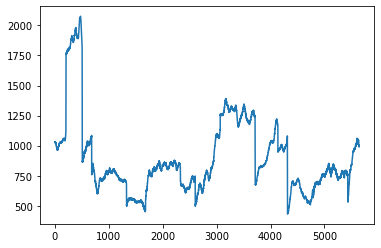

In [44]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

test_score = np.array(test_score).squeeze()
plt.plot(test_score)